# Module 7 - Temperature, Energy, Pressure and Simulation Ensembles

# Goals

- Learn how to define the energy, temperature, and pressure of a simulated system
- Learn about methods to keep temperature and pressure constant in MD simulations

# Kinetic, Potential, and Total Energy

The total energy, $E$, of a molecular system is equal to the sum of the potential, $V$, and kinetic, $K$, energies, $E=V+K$. The kinetic energy can be obtained from the masses, $m_i$, and velocities, $v_i$, of particles in the system

$$ K = \frac{1}{2}\sum^N_i m_i v_i^2,$$

where $N$ is the total number of particles. Similarly, the potential energy can be obtained from the particle positions based on the interatomic potential(s) acting on the system:

$$ V = \sum^N_i \sum^N_{j>i} V_{ij}(r_{ij}),$$

where $r_{ij}=|\vec{r}_i-\vec{r}_j|$ is the distance between two particles $i$ and $j$.

The temperature of a molecular system may be defined from the equipartition theorem as

$$ T = \frac{1}{N_{\mathrm{dof}}k_{\mathrm{B}}} \sum^N_i m_i v_i^2,$$

where $k_{\mathrm{B}}$ is the Boltzmann constant and $N_{\mathrm{dof}}$ is the *number of degrees of freedom*. While it may be tempting to think that $N_{\mathrm{dof}}$ is just equal to the number of particles, one must also take care of removing degrees of freedom that are lost to for example removing the center of mass motion, $v_{\mathrm{COM}=0}$, or the use of rigid bond constraints.

Similarly, the pressure is defined as

$$ P = \frac{1}{3V} \left( \sum^N_i \sum^N_{j>i} f_{ij} ~ r_{ij} + \sum^N_i m_i v_i^2 \right),$$

where $f_{ij}$ is the interaction force between two particles. Note that the equation above is for the *scalar* pressure, but in general the pressure is a tensor,

$$ \boldsymbol{P} = \begin{bmatrix}
P_{xx} & P_{xy} & P_{xz} \\
P_{yx} & P_{yy} & P_{yz} \\
P_{zx} & P_{zy} & P_{zz} 
\end{bmatrix}. $$

The scalar pressure is obtained from the trace of the pressure tensor, $P=(P_{xx}+P_{yy}+P_{zz})/3$. The general equation for the pressure tensor in vector notation is

$$ \boldsymbol{P} = \frac{1}{V} \left( \sum^N_i \sum^N_{j>i} \boldsymbol{f}_{ij} \otimes \boldsymbol{r}_{ij} + \sum^N_i m_i \boldsymbol{v}_i \otimes \boldsymbol{v}_i \right).$$

Note that in many physics and engineering fields they define the stress tensor, $\boldsymbol{\sigma}=-\boldsymbol{P}$, instead of the pressure. The choice between these two quantities is a matter of mathematical convenience on whether to characterize the forces that the surroundings exert on a body vs. the forces that the body exerts on its surrounding.

## Let's compute the Energy, Pressure, and Temperature for our solid Argon system!!

In [1]:
# Let's import all the methods we'll need later on
from ase.lattice.cubic import FaceCenteredCubic
from ase import units
from ase.calculators.lj import LennardJones as LJ
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.verlet import VelocityVerlet
from ase.visualize import view
from ase.io.trajectory import Trajectory
from ase.md.nptberendsen import NVTBerendsen,NPTBerendsen
import numpy as np
import matplotlib.pyplot as plt

We'll start by creating our Ar crystal as before, adding the Lennard-Jones calculator, setting the initial velocities from the Maxwell-Boltzmann distribution, and initializing the `md` object using the `VelocityVerlet` method.

In [2]:
# Set up the crystal, which will be stored in an object called 'Ar_atoms'
# Our system is made of 2x2x2 unit cells with a total of 32 atoms (4 atoms per unit cell).
Ar_atoms = FaceCenteredCubic(directions=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
                             symbol='Ar',
                             latticeconstant=5.25*units.Ang,
                             size=(2, 2, 2),
                             pbc=True)

# Describe the interatomic interactions using a Lennard-Jones potential
Ar_atoms.calc = LJ(sigma=3.4*units.Ang, epsilon=0.9889744*units.kJ/units.mol, rc=15*units.Ang)

# Set the initial particle velocities using a Maxwell-Boltzmann distribution for a given temperature
MaxwellBoltzmannDistribution(atoms=Ar_atoms, temperature_K=40)
Stationary(Ar_atoms)

# Setup an md instance based on our `Ar_atoms` object
md = VelocityVerlet(atoms=Ar_atoms, timestep=5, trajectory='md.traj', loginterval=10)  # 5 fs time step.

Before executing the MD simulation, we are going to create a function called `get_props()` which will extract the potential, kinetic, and total energies as well as the temperature and pressure at any given step in the simulation. To do this, we will make use of several methods that are built-in into all ASE `atoms` objects which will extract a given quantity for a particular configuration, e.g., `atoms.get_potential_energy()` or `atoms.get_temperature()`. Note that ASE computes the stress tensor and stores it in a 6x1 array, $\boldsymbol{\sigma}=[\sigma_{xx},\sigma_{yy},\sigma_{zz},\sigma_{xy},\sigma_{xz},\sigma_{yz}]$. We need the first 3 elements of the stress tensor to compute the scalar pressure for our system.

The function `get_props()` will be 'attached' to the md object and it will append the data to an empty list which we can use later to plot the results. 

In [3]:
props=[]
def get_props(md=md, a=Ar_atoms, props=props):
    PE = a.get_potential_energy()*96 # Unit conversion from eV to kJ/mol
    KE = a.get_kinetic_energy()*96
    E = a.get_total_energy()*96
    T = a.get_temperature()
    stress = a.get_stress()*1602176.6208 # Unit conversion from eV/A^3 to atmospheres
    P = -(stress[0]+stress[1]+stress[2])/3.0 # Compute the scalar pressure from the stress tensor
    time = md.get_time()
    props.append([time,PE,KE,E,T,P])

# Attach the get_props() function so that it computes our quantities at a given interval
md.attach(get_props, interval=1)

# we call get_props() once before running md to get the properties for the very first time step
get_props()

# run the simulation
md.run(100)

True

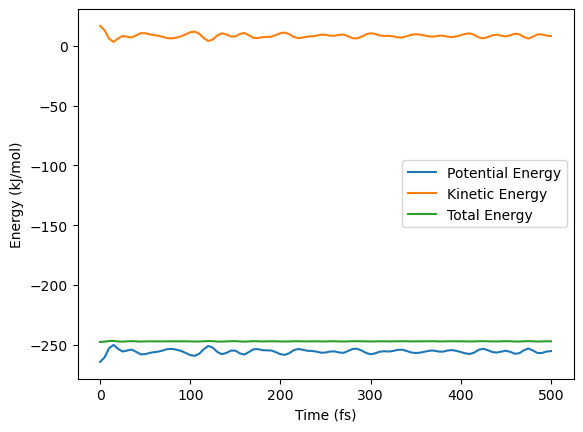

In [4]:
props =np.array(props) # convert to a numpy array before plotting

# Plot the energies
plt.figure()
plt.xlabel('Time (fs)')
plt.ylabel('Energy (kJ/mol)')
plt.plot(props[:,0], props[:,1], label='Potential Energy')
plt.plot(props[:,0], props[:,2], label='Kinetic Energy')
plt.plot(props[:,0], props[:,3], label='Total Energy')
plt.legend()

In [ ]:
# Plot temperature
plt.figure()
plt.xlabel('Time (fs)')
plt.ylabel('Temperature (K)')
plt.plot(props[:,0], props[:,4])

# Plot pressure
plt.figure()
plt.xlabel('Time (fs)')
plt.ylabel('Pressure (atm)')
plt.plot(props[:,0], props[:,5])

<div class="span alert alert-success">
<h2> Programming challenge </h2>
    
Copy the working code above and paste it in the cell below. Modify it to drive the formation of a liquid/gas phase by increasing the lattice constant by 15% and the initial temperature to 120 K. Plot the energies, temperature, and pressure for this liquid system.

In [5]:
# Set up the crystal, which will be stored in an object called 'Ar_atoms'
# Our system is made of 2x2x2 unit cells with a total of 32 atoms (4 atoms per unit cell).
Ar_atoms = FaceCenteredCubic(directions=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
                             symbol='Ar',
                             latticeconstant=1.15*5.25*units.Ang,
                             size=(2, 2, 2),
                             pbc=True)

# Describe the interatomic interactions using a Lennard-Jones potential
Ar_atoms.calc = LJ(sigma=3.4*units.Ang, epsilon=0.9889744*units.kJ/units.mol, rc=15*units.Ang)

# Set the initial particle velocities using a Maxwell-Boltzmann distribution for a given temperature
MaxwellBoltzmannDistribution(atoms=Ar_atoms, temperature_K=120)
Stationary(Ar_atoms)

# Setup an md instance based on our `Ar_atoms` object
md = VelocityVerlet(atoms=Ar_atoms, timestep=5, trajectory='md.traj', loginterval=10)  # 5 fs time step.

# reset the props list to be empty before we run the new simulation
props = []
def get_props(md=md, a=Ar_atoms, props=props):
    PE = a.get_potential_energy()*96 # Unit conversion from eV to kJ/mol
    KE = a.get_kinetic_energy()*96
    E = a.get_total_energy()*96
    T = a.get_temperature()
    stress = a.get_stress()*1602176.6208 # Unit conversion from eV/A^3 to atmospheres
    P = -(stress[0]+stress[1]+stress[2])/3.0 # Compute the scalar pressure from the stress tensor
    time = md.get_time()
    props.append([time,PE,KE,E,T,P])

# Attach the get_props() function so that it computes our quantities at a given interval
md.attach(get_props, interval=1)

# we call get_props() once before running md to get the properties for the very first time step
get_props()

# run the simulation
md.run(100)

True

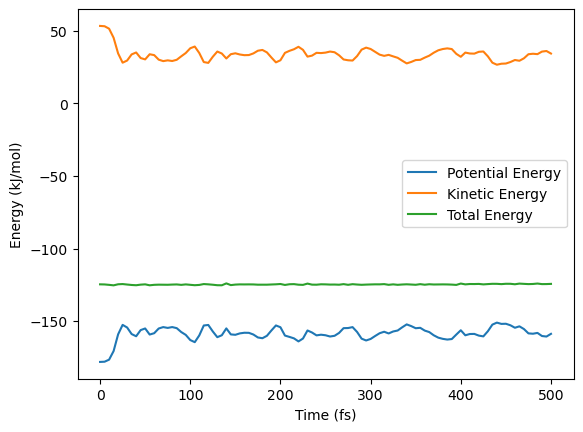

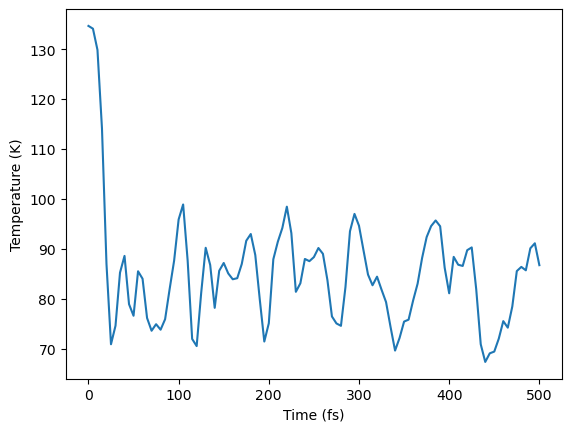

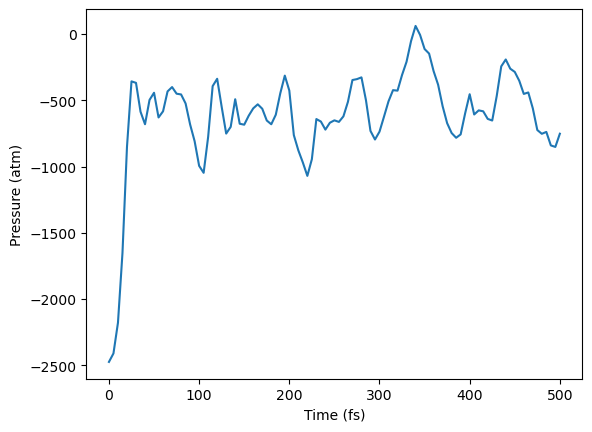

In [6]:
props =np.array(props) # convert to a numpy array before plotting

# Plot the energies
plt.figure()
plt.xlabel('Time (fs)')
plt.ylabel('Energy (kJ/mol)')
plt.plot(props[:,0], props[:,1], label='Potential Energy')
plt.plot(props[:,0], props[:,2], label='Kinetic Energy')
plt.plot(props[:,0], props[:,3], label='Total Energy')
plt.legend()

# Plot temperature
plt.figure()
plt.xlabel('Time (fs)')
plt.ylabel('Temperature (K)')
plt.plot(props[:,0], props[:,4])

# Plot pressure
plt.figure()
plt.xlabel('Time (fs)')
plt.ylabel('Pressure (atm)')
plt.plot(props[:,0], props[:,5])

In [ ]:
# Load the trajectory from file
traj = Trajectory('md.traj')
view(traj, viewer='ngl')

<div class="span alert alert-success">
<h2> Programming challenge </h2>
    
Explore changing the value of the lattice constant between 5-15% of the original lattice size as well as the initial temperature between 100-150 K. Running 100 simulation steps should be suffcient. Re-plot the energies, temperature, and pressure for this liquid system. Use the trajectory visualization to also see how the system behaves.

## Dynamics and Ensemble averages

In MD simulations we 'watch' the evolution a system of interest over time by integrating Newton's equations of motion. The time trajectories that result from an MD simulation can provide useful insights into the dynamics of the system as well as average properties. To compute average properties, we assume that our time trajectory is effectively exploring the configurational/conformational space available to our system. Therefore, we can compute thermodynamic averages by taking a time average of an observable of interest ($A$, e.g., energy)

\begin{align}
    \langle A \rangle = \frac{1}{N_t}\sum_{n}^{N_t} A(t_n),
\end{align}

where $t_n$ is a specific time of the trajectory (likely sampled uniformly), $A(t_n)$ is the value of the observable at that sepcific time, and $N_t$ is the total number time frames sampled. We use this time average to take place of the thermodynamic average

\begin{align}
    \langle A \rangle = \sum_{i} P(E_i) A(E_i)
\end{align}

as long as we have adequate sampling and our system is at equilibrium. 

## Equilibration

It is often difficult to start a simulation from a configuration that is close to equilibrium. Therefore, there is an initial time period in most MD simulations where the system properties are continuously changing until they reach a steady state where properties fluctuate around a given value without drifting away. The length of equilibration phase will depend on the physical properties of the system as well as simulation conditions. Time averages of any propertie of interest should exclude this equilibration period and only use trajectory frames where the system is in a steady state.

<div class="span alert alert-success">
<h2> Programming challenge </h2>
    
Compute the average value of the energies, temperature, and pressure. Use the numpy array slicing and methods to compute these. For example, to get the mean value of an array called `A` you can use the command `A.mean()`. To compute the mean of only a certain subset of the data, say the last 50 elements, use slicing, `A[50:].mean()`. Compare your average values to histograms of the data using the matplotlib `plt.hist(A)` method. Do your average values agree with the histograms? What happens if you use all the time data including the equilibration period?

34.009110971965654


(array([13., 20., 32., 24.,  8.,  0.,  1.,  0.,  0.,  4.]),
 array([26.73170292, 29.40565843, 32.07961394, 34.75356945, 37.42752495,
        40.10148046, 42.77543597, 45.44939148, 48.12334699, 50.7973025 ,
        53.471258  ]),
 <BarContainer object of 10 artists>)

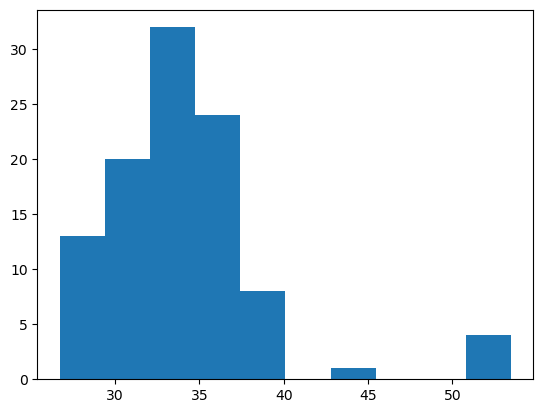

In [12]:
plt.figure()
print(props[:,2].mean())
plt.hist(props[:,2])

## Temperature and Pressure Control

The temperature and pressure in a simulation can be controlled by algorithms known as **thermostats** and **barostats**. A thermostat acts like a 'heat bath' that controls the temperature so that it remains near a desired value. A simple example of a thermostating algorithm is known as the **isokinetic or Gaussian thermostat**, which is broken into 3 steps:

- Compute the future velocities ($v(t+\Delta t$) using an algorithm such as Verlet or velocity-Verlet
- Compute the the temperature of the future timestep, $T(t+\Delta t)$
- Re-scale the futuure velocities using the relation $v^{\mathrm{new}}(t+\Delta t)=\sqrt{\frac{T_{\mathrm{ref}}}{T(t+\Delta t)}}v(t+\Delta t)$
- Remove the center of mass velocity in order to prevent drifting of the system in space (the flying ice cube problem)

While the isokinetic thermostat is effective in keeping the temperature fixed at some reference value, it can lead to numerous problems including abrupt changes in the velocities and improper sampling of the energy. Sampling of the energy is very important as statistical mechanics indicates that a system that is under a constant temperature, constant number of particles, and constant volume ($NVT$, also known as the canonical ensemble) must have certain properties. For a system in the canonical ensemble, the energy will not be constant but it will fluctuate around and equilibrium value $\langle E \rangle$. The fluctuations in the energy, $\langle E^2 \rangle$, are also determined by the canonical ensemble.

Most thermostats don't try fix the temperature so that the instantaneous value is constant at every time step, but instead gently adjust the kinetic energy at given intervals so that the average temperature, $\langle T \rangle$, oscillates near a desired value with some characteristic oscillation time, $\tau_T$. A complete discussion on various thermostating techiques is beyond the scope our class. A widely used thermostat that fulfills all our desired qualities (correct average energy and fluctuations as well as fast relaxation to the correct temperature) is the **stochastic velocity-rescaling** algorithm by Bussi, Donadio, and Parrinello (J. Chem. Phys. 126, 2007, 014101. https://doi.org/10.1063/1.2408420)

Analogous to a thermostat, a barostat maintains the average pressure of system constant by effectively coupling the simulation cell to a 'piston' that changes the size accordingly. When running an MD simulation under constant number of particles, constant pressure, and constant temperature, it is said to be in the isothermal-isobaric ensemble ($NPT$). Most barostats don't try fix the pressure so that the instantaneous value is constant at every time step, but instead gently adjust the simulation cell dimensions (and sometimes the positions/veloities) at given intervals so that the average pressure, $\langle P \rangle$ oscillates near a desired value with some characteristic oscillation time, $\tau_P$. Similarly to the canonical ensemble, a system in the isothermal-isobaric ensemble will have a volume that oscillates around an equilibrium value, $\langle V \rangle$, and will have certain volume fluctuations, $\langle V^2 \rangle$. A recently developed barostat that fulfills all our desired qualities (correct average volume and fluctuations as well as fast relaxation to the correct pressure) is **the stochastic cell-rescaling** algorithm by Bernetti and Bussi (J. Chem. Phys. 153, 2020, 114107. https://doi.org/10.1063/5.0020514).

## References for a Complete Discussion of Thermostats and Barostats

*Statistical Mechanics: Theory and Molecular Simulation* by Mark Tuckerman

*Understanding Molecular Simulation: From Algorithms to Applications* by Frenkel and Smit

## GROMACS!!

<img src="https://www.gromacs.org/_static/gmx_logo_blue.png" width=600px>

Given the speed limitations of the built-in algorithms in ASE, we will explore the effects of thermostats and barostats on our systems using the open-source GROMACS simulation package (https://www.gromacs.org/). GROMACS (GRoningen MAchine for Chemical Simulations) is a collection of tools for setting up, running, and analyzing MD simulations. GROMACS was originally developed at the University of Groningen by Herman Berendsen and others. It's current development is led by researchers at the KTH-Royal Institute of Technology and Uppsala University in Sweden. GROMACS is one of the fastest MD simulation packages due to its highly hardware optimized algorithms.

## Running a simulation in GROMACS

To run a simulation in GROMACS you need a *minimum* of 3 components:

- Structure file that has the starting positions (and sometimes velocities) of your system of interest. This is usully a .pdb (protein databank format) or .gro (GROMACS format) file
- Topology file(s) that describe the interatomic potential interactions. These are simple text files with .itp or .top extensions which describe the types of interactions (e.g., Lennard-Jones, electrostatics, bonds, etc.), number of molecules/atoms in the system, etc.
- MD parameters file (.mdp). This text file contains all the simulation parameters including the time step, number of steps, integration algorithm, temperature, pressure, etc.

Before running the MD simulation, we must parse them first by the command `gmx grompp`, which is the GROMACS pre-processor. `gmx grompp` checks that the text inputs are free of errors and that the chosen parameters are physically reasonable. If the command is successful, it will produce a binary file with an extension .tpr. The produced binary .tpr file can then be used by `gmx mdrun` to run our MD simulation